In [7]:
import numpy as np
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [20]:
low = 1
high = 10
diff = high - low

A = np.random.random(size = (3))*diff + low
B = np.random.random(size = (3))*diff + low
C = np.random.random(size = (3))*diff + low

tr = [A,B,C]

pt_internes = []
for _ in range(10000):
    a = np.random.rand()
    b = np.random.rand()*(1-a)
    c = 1 - a - b
    New_pt = c*C + a*A + b*B
    pt_internes.append(New_pt)

In [91]:
k = [1,4,3]
tuple(k.remove(k[1]))

TypeError: 'NoneType' object is not iterable

In [75]:
def projection(Tr,P):
    "projete le point x sur le triangle tr"
    # On projette les deux points sur le plan du triangle et on s'assure que c'est dedans
    A = Tr[0]
    B = Tr[1]
    C = Tr[2]
    #Calcul du vecteur normal
    N = np.cross(B-A,B-C)
    n = N/np.linalg.norm(N)
    d = np.dot(n,P-A)
    return P - d*n

def area_of_triangle(Tr):
    "calcule l'aire d'un triangle array"
    p1, p2, p3 = Tr[0], Tr[1], Tr[2]
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

def intersection(Tr,P,Q):
    "determine l'intersection entre PQ et le plan du triangle Tr "
    A = projection(Tr,P)
    B = projection(Tr,Q)
    # on cherche l'intersectionn entre BA et PQ
    if 0 in P-Q :
        ind = 3
    
    a,a_p = tuple(list(B-A)[:2])
    b,b_p = tuple(list(P-Q)[:2])
    c,c_p = tuple(list(P-A)[:2])
    print((a*b_p - a_p*b))
    t = (a*c_p - a_p*c)/(a*b_p - a_p*b)
    lbda = (c*b_p - c_p*b)/(a*b_p - a_p*b)
    assert np.isclose(P +t*(Q-P), A+lbda*(B-A)).all() ,(P +t*(Q-P), A+lbda*(B-A))
    return P +t*(Q-P)


def is_inside(Tr,P): 
    "determine si un point P est à l'intérieur d'un triangle Tr"
    A, B, C = Tr[0], Tr[1], Tr[2]
    Tr1 = [A,B,P]
    Tr2 = [A,C,P]
    Tr3 = [B,C,P]
    Somme = area_of_triangle(Tr1) + area_of_triangle(Tr2) + area_of_triangle(Tr3)
    Total = area_of_triangle(Tr)
    # assert(Total <= Somme), "Error dans le test"
    return np.isclose(Somme ,Total)

def traverse(Tr,P,Q):
    "determine si PQ traverse Tr"
    # les points P et Q  doivent etre dans deux sens opposés de de tr
    P_proj = projection(Tr,P)
    Q_proj = projection(Tr,Q)
    n_P = (P - P_proj)
    n_Q = (Q - Q_proj)
    print(np.dot(n_P,n_Q))
    if np.dot(n_P,n_Q) > 0 :
        return False
    Z = intersection(Tr,P,Q)
    return is_inside(Tr,Z) 



## Visualize and test the method

(0.20255837065996873, 4.4618480995434115)

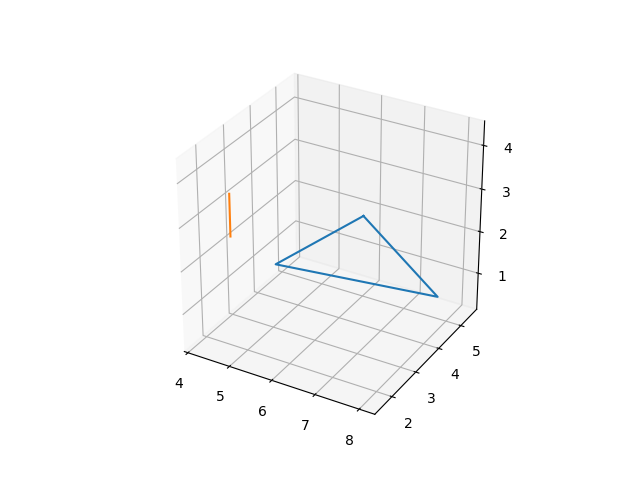

In [79]:
X,Y,Z = [],[],[]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')


xs = [ind[0] for ind in tr] + [tr[0][0]]
ys = [ind[1] for ind in tr] + [tr[0][1]]
zs = [ind[2] for ind in tr] + [tr[0][2]]
ax.plot(xs,ys,zs)

X = X + list(xs)
Y = Y + list(ys)
Z = Z + list(zs)


ax.plot([P[0],Q[0]],[P[1],Q[1]],[P[2],Q[2]])

X= X + [P[0],Q[0]]
Y = Y +[P[1],Q[1]]
Z = Z + [P[2],Q[2]]

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5

ax.grid(True)

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

In [73]:
cpt = 0
#Calcul du vecteur normal
N = np.cross(B-A,B-C)
n = N/np.linalg.norm(N)
K = []
for i in pt_internes:
    i = i + 10*(1- 2*np.random.rand())*n
    K.append(i)
    if not in_prism(tr,i):
        print("Error")
        cpt = cpt + 1

## Apply it to mesh

In [43]:
def detect_edges(Tr):
    x_coords = [point[0] for point in Tr]
    y_coords = [point[1] for point in Tr]
    z_coords = [point[2] for point in Tr]

    # Calculate min and max for each dimension with integer bounds
    x_min = math.floor(min(x_coords))
    y_min = math.floor(min(y_coords))
    z_min = math.floor(min(z_coords))

    x_max = math.ceil(max(x_coords))
    y_max = math.ceil(max(y_coords))
    z_max = math.ceil(max(z_coords))   

    """Gives all the edges in the 3D grid 
    with the xyz limitaion"""
    edges = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            for z in range(z_min, z_max + 1):
                # Add edges parallel to the x-axis
                if x < x_max:
                    edges.append(((x, y, z), (x + 1, y, z)))
                # Add edges parallel to the y-axis
                if y < y_max:
                    edges.append(((x, y, z), (x, y + 1, z)))
                # Add edges parallel to the z-axis
                if z < z_max:
                    edges.append(((x, y, z), (x, y, z + 1)))
    
    return edges

In [44]:
S = []
for P,Q in detect_edges(tr):
    print(P,Q)
    if traverse(tr,np.array(P),np.array(Q)):
        S.append((P,Q))


(4, 2, 1) (5, 2, 1)
(4, 2, 1) (4, 3, 1)
(4, 2, 1) (4, 2, 2)
(4, 2, 2) (5, 2, 2)
(4, 2, 2) (4, 3, 2)
(4, 2, 2) (4, 2, 3)
(4, 2, 3) (5, 2, 3)
(4, 2, 3) (4, 3, 3)
(4, 2, 3) (4, 2, 4)
(4, 2, 4) (5, 2, 4)
(4, 2, 4) (4, 3, 4)
(4, 3, 1) (5, 3, 1)
(4, 3, 1) (4, 4, 1)
(4, 3, 1) (4, 3, 2)
(4, 3, 2) (5, 3, 2)
(4, 3, 2) (4, 4, 2)
(4, 3, 2) (4, 3, 3)


/tmp/ipykernel_232747/879349538.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  t = (a*c_p - a_p*c)/(a*b_p - a_p*b)
/tmp/ipykernel_232747/879349538.py:27: RuntimeWarning: invalid value encountered in scalar divide
  lbda = (c*b_p - c_p*b)/(a*b_p - a_p*b)
/tmp/ipykernel_232747/879349538.py:28: RuntimeWarning: invalid value encountered in multiply
  assert np.isclose(P +t*(Q-P), A+lbda*(B-A)).all() ,(P +t*(Q-P), A+lbda*(B-A))


AssertionError: (array([nan, nan, inf]), array([nan, nan, nan]))

In [76]:
P,Q = (4, 3, 2),(4, 3, 3)
P_proj = projection(tr,P)
Q_proj = projection(tr,Q)
n_P = (P - P_proj)
n_Q = (Q - Q_proj)
(np.dot(n_P,n_Q) )

-0.011605431524011462

False

In [70]:
P

(4, 3, 2)

In [77]:
traverse(tr,np.array(P),np.array(Q))

-0.011605431524011462
0.0


/tmp/ipykernel_232747/4119483970.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  t = (a*c_p - a_p*c)/(a*b_p - a_p*b)
/tmp/ipykernel_232747/4119483970.py:28: RuntimeWarning: invalid value encountered in scalar divide
  lbda = (c*b_p - c_p*b)/(a*b_p - a_p*b)
/tmp/ipykernel_232747/4119483970.py:29: RuntimeWarning: invalid value encountered in multiply
  assert np.isclose(P +t*(Q-P), A+lbda*(B-A)).all() ,(P +t*(Q-P), A+lbda*(B-A))


AssertionError: (array([nan, nan, inf]), array([nan, nan, nan]))

In [48]:
P,Q = (4, 3, 2),(4, 3, 3)
P = np.array(P)
Q = np.array(Q)

In [49]:
Q

array([4, 3, 3])